In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor , Lambda
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import Conv2d , Dropout , MaxPool2d
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\Morteza\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
training_data = datasets.MNIST(
    root="raw",
    train=True,
    download=True,
    transform=ToTensor(),
)
testing_data = datasets.MNIST(
    root="raw",
    train=False,
    download=True,
    transform=ToTensor(),
)
# Store in Dataloader
train_dataloader = DataLoader(training_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(testing_data,batch_size=32,shuffle=True)

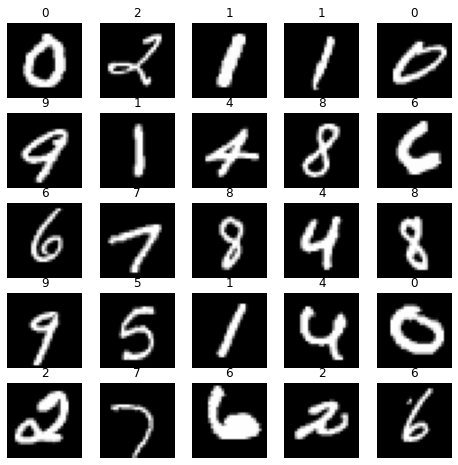

In [4]:
def plot_samples(cols=3,rows=3):
  figure = plt.figure(figsize=(8, 8))
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(training_data), size=(1,)).item()
      img, label = training_data[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(str(label))
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
  plt.show()
plot_samples(5,5)

In [6]:
class ForwardNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.Network = nn.Sequential(
        nn.Linear(28*28,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,10),
        nn.Softmax()
    )

  def forward(self,X):
    X = self.flatten(X)
    X = self.Network(X)
    return X

  
  def train_epoch(self,optimizer,loss_fn,dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss,correct = 0,0
    for batch, (X, y) in enumerate(dataloader):
      # Compute prediction and loss
      pred = self.forward(X)
      
      loss = loss_fn(pred, y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    with torch.no_grad():
      for X,y in dataloader:
        pred = self.forward(X)
        train_loss += loss_fn(pred,y).item()
        correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    train_loss/=num_batches
    correct/=size
    print(f"Train Accuracy: {(100*correct):>0.1f}%, Avg train loss: {train_loss:>8f}  ")
    return correct , train_loss
      

  def test_epoch(self,dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = self.forward(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Accuracy: {(100*correct):>0.1f}%, Avg test loss: {test_loss:>8f} \n")
    return correct , test_loss
    

  
  def fit(self,loss_fn,optimizer,epochs,train_dataloader,test_dataloader):
    train_acc,train_loss,test_acc,test_loss = np.zeros(epochs),np.zeros(epochs),np.zeros(epochs),np.zeros(epochs)
    for epoch in range(epochs):
      print(f"Epoch {epoch+1}  ")
      train_accuracy , train_cost = self.train_epoch(optimizer,loss_fn,train_dataloader)
      test_accuracy , test_cost = self.test_epoch(test_dataloader,loss_fn)
      train_acc[epoch] = train_accuracy
      train_loss[epoch] = train_cost
      test_acc[epoch] = test_accuracy
      test_loss[epoch] = test_cost
    print("Done!")
    return train_acc,train_loss,test_acc,test_loss

In [7]:
model = ForwardNeuralNetwork()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)#,weight_decay=1e-4)
epochs = 10
loss_fn = nn.CrossEntropyLoss()
train_acc,train_loss,test_acc,test_loss = model.fit(
    loss_fn,
    optimizer,
    epochs,
    train_dataloader,
    test_dataloader
)

Epoch 1  


/home/morteza/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Accuracy: 64.6%, Avg train loss: 1.817881  
Test Accuracy: 64.9%, Avg test loss: 1.814369 

Epoch 2  
Train Accuracy: 66.1%, Avg train loss: 1.799257  
Test Accuracy: 66.0%, Avg test loss: 1.799678 

Epoch 3  
Train Accuracy: 66.5%, Avg train loss: 1.794490  
Test Accuracy: 66.4%, Avg test loss: 1.795208 

Epoch 4  
Train Accuracy: 74.3%, Avg train loss: 1.720697  
Test Accuracy: 74.0%, Avg test loss: 1.722795 

Epoch 5  
Train Accuracy: 75.7%, Avg train loss: 1.703990  
Test Accuracy: 75.2%, Avg test loss: 1.707470 

Epoch 6  
Train Accuracy: 76.5%, Avg train loss: 1.694032  
Test Accuracy: 76.0%, Avg test loss: 1.699152 

Epoch 7  
Train Accuracy: 76.7%, Avg train loss: 1.693346  
Test Accuracy: 76.0%, Avg test loss: 1.700118 

Epoch 8  
Train Accuracy: 77.0%, Avg train loss: 1.688814  
Test Accuracy: 76.4%, Avg test loss: 1.694229 

Epoch 9  
Train Accuracy: 86.9%, Avg train loss: 1.593133  
Test Accuracy: 86.1%, Avg test loss: 1.600279 

Epoch 10  
Train Accuracy: 87.2%, Avg 

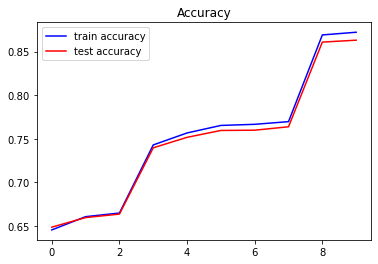

In [8]:
plt.plot(train_acc,c='b',label='train accuracy')
plt.plot(test_acc,c='r',label='test accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

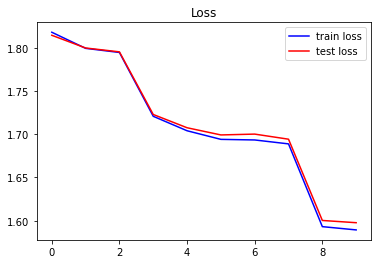

In [9]:
plt.plot(train_loss,c='b',label='train loss')
plt.plot(test_loss,c='r',label='test loss')
plt.title("Loss")
plt.legend()
plt.show()

In [65]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.ConvNetwork = nn.Sequential(
            Conv2d(1,10,5),
            nn.ReLU(),
            MaxPool2d(2),
            Conv2d(10,16,5),
            nn.ReLU(),
            MaxPool2d(2)
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(256,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10),
#             nn.Softmax()
        )
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.log_prob_loss = nn.LogSoftmax(dim=-1)
        self.optimizer = torch.optim.Adam(params=self.parameters(),lr=1e-3)
        
    def forward(self,X):
        X = self.ConvNetwork(X)
        X = X.view(X.shape[0], -1)
        X = self.fully_connected(X)
        return X
    
    def train_epoch(self,dataloader):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        train_loss,correct = 0,0
        for batch, (X, y) in enumerate(dataloader):
          # Compute prediction and loss
          pred = self.forward(X)
          loss_fn = self.cross_entropy_loss(pred, y)

          # Backpropagation
          self.optimizer.zero_grad()
          loss_fn.backward()
          self.optimizer.step()

        with torch.no_grad():
          for X,y in dataloader:
            pred = self.forward(X)
            train_loss += self.cross_entropy_loss(pred,y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
        train_loss/=num_batches
        correct/=size
        print(f"Train Accuracy: {(100*correct):>0.1f}%, Avg train loss: {train_loss:>8f}  ")
        return correct , train_loss
    
    def test_epoch(self,dataloader):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0
#         loss_fn = self.cross_entropy_loss()
        with torch.no_grad():
            for X, y in dataloader:
                pred = self.forward(X)
                test_loss += self.cross_entropy_loss(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(f"Test Accuracy: {(100*correct):>0.1f}%, Avg test loss: {test_loss:>8f} \n")
        return correct , test_loss
    
    def fit(self,train_dataloader,test_dataloader,epochs):
        train_acc = np.zeros(epochs)
        train_loss = np.zeros(epochs)
        test_acc = np.zeros(epochs)
        test_loss = np.zeros(epochs)
        for epoch in range(epochs):
          print(f"Epoch {epoch+1}  ")
          train_accuracy , train_cost = self.train_epoch(train_dataloader)
          test_accuracy , test_cost = self.test_epoch(test_dataloader)
          train_acc[epoch] = train_accuracy
          train_loss[epoch] = train_cost
          test_acc[epoch] = test_accuracy
          test_loss[epoch] = test_cost
        print("Done!")
        # save the model
        torch.save(self.state_dict)
        return train_acc,train_loss,test_acc,test_loss
                

In [66]:
model = LeNet5()
train_acc , train_loss , test_acc , test_loss = model.fit(
    train_dataloader,
    test_dataloader,
    epochs = 10
)

Epoch 1  
Train Accuracy: 97.6%, Avg train loss: 0.076647  
Test Accuracy: 97.8%, Avg test loss: 0.069600 

Epoch 2  
Train Accuracy: 98.4%, Avg train loss: 0.049292  
Test Accuracy: 98.3%, Avg test loss: 0.054251 

Epoch 3  
Train Accuracy: 98.7%, Avg train loss: 0.039273  
Test Accuracy: 98.5%, Avg test loss: 0.046541 

Epoch 4  
Train Accuracy: 99.0%, Avg train loss: 0.032240  
Test Accuracy: 98.5%, Avg test loss: 0.046903 

Epoch 5  
Train Accuracy: 99.2%, Avg train loss: 0.024016  
Test Accuracy: 98.9%, Avg test loss: 0.037780 

Epoch 6  
Train Accuracy: 99.3%, Avg train loss: 0.021054  
Test Accuracy: 99.0%, Avg test loss: 0.036739 

Epoch 7  
Train Accuracy: 99.6%, Avg train loss: 0.012438  
Test Accuracy: 99.1%, Avg test loss: 0.032303 

Epoch 8  
Train Accuracy: 99.5%, Avg train loss: 0.013809  
Test Accuracy: 99.1%, Avg test loss: 0.033366 

Epoch 9  
Train Accuracy: 99.7%, Avg train loss: 0.011685  
Test Accuracy: 99.0%, Avg test loss: 0.034732 

Epoch 10  
Train Accuracy: 9

TypeError: save() missing 1 required positional argument: 'f'

In [78]:
def plot_eval(train_acc,test_acc,train_loss,test_loss):
    fig = plt.figure(figsize=(13,6))
    # loss
    ax = fig.add_subplot(121)
    ax.set_title('Loss / Epoch')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_aspect('auto')
    plt.plot(train_loss, label='Train', color='blue', linewidth=3)
    plt.plot(test_loss, label='Validation', color='red', linewidth=3)
    plt.legend()
    # acc
    ax = fig.add_subplot(122)
    ax.set_title('Accuracy / Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_aspect('auto')
    plt.plot(train_acc, label='Train', color='blue', linewidth=3)
    plt.plot(test_acc, label='Validation', color='red', linewidth=3)
    plt.legend()

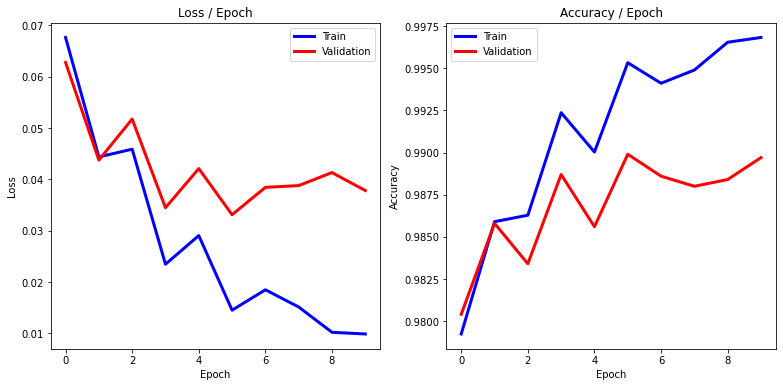

In [79]:
plot_eval(train_acc,test_acc,train_loss,test_loss)

In [ ]:
# Transfer learning with residual network